Выполнила: Анастасия Плавина

## Урок 4. Uplift-моделирование

### 1. Цель
Предсказание конверсии клиента в рамках маркетинговой промоакции для максимизации профита маркетинговой кампании и сокращении затрат на ее организацию.

### 2. Описание данных

Данные о клиентах объемом 6400.

- recency - количество месяцев с последней покупки
- history - количество покупок за все время
- used_discount - индикатор использования скидки
- used_bogo - индикатор использования акции "два по цене одного"
- zip_code - характеристика местоположения Suburban/Urban/Rural 
- is_referral - индикатор того, что клиент привлечен через реферальную программу
- channel - канал взаимодейтсвия Phone/Web/Multichannel
- offer - оказанное воздействие Discount/But One Get One/No Offer
- conversion - конверсия (была ли совершена покупка)

### 3. Загрузка данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
# Инструкция по установке пакета: https://github.com/maks-sh/scikit-uplift
# Ссылка на документацию: https://scikit-uplift.readthedocs.io/en/latest/
from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_by_percentile
from sklift.models import SoloModel

from IPython.display import Image
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.inference.tree import uplift_tree_string, uplift_tree_plot



# sklift поддерживает любые модели, 
# которые удовлетворяют соглашениями scikit-learn
# Для примера воспользуемся catboost
from catboost import CatBoostClassifier

sns.set_style('darkgrid')

In [2]:
df = pd.read_csv('data.csv')
df.head(5)

recency  history  used_discount  used_bogo   zip_code  is_referral channel  \
0       10   142.44              1          0  Surburban            0   Phone   
1        6   329.08              1          1      Rural            1     Web   
2        7   180.65              0          1  Surburban            1     Web   
3        9   675.83              1          0      Rural            1     Web   
4        2    45.34              1          0      Urban            0     Web   

             offer  conversion  
0  Buy One Get One           0  
1         No Offer           0  
2  Buy One Get One           0  
3         Discount           0  
4  Buy One Get One           0

In [3]:
# переименовываем колонки
df.rename(columns={'offer': 'treatment', 'conversion': 'target'}, inplace=True)

# зприводим treatment к бинарному виду
df.loc[df['treatment'].isin(['Discount','Buy One Get One']), 'treatment'] = 1 
df.loc[df['treatment'] == 'No Offer', 'treatment'] = 0 
df['treatment'] = df['treatment'].astype(int)
df['treatment'].unique()

array([1, 0])

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64000 entries, 0 to 63999
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   recency        64000 non-null  int64  
 1   history        64000 non-null  float64
 2   used_discount  64000 non-null  int64  
 3   used_bogo      64000 non-null  int64  
 4   zip_code       64000 non-null  object 
 5   is_referral    64000 non-null  int64  
 6   channel        64000 non-null  object 
 7   treatment      64000 non-null  int64  
 8   target         64000 non-null  int64  
dtypes: float64(1), int64(6), object(2)
memory usage: 4.4+ MB


### 4. Обзор целевой переменной

Соотношение целевой переменной:
0 (нет конверсии) - 85%
1 (конверсия) - 15%


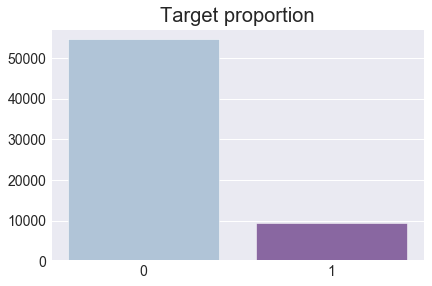

In [5]:
target = 'target'
features = df.columns.drop(target).tolist()

counts = df[target].value_counts()

print('Соотношение целевой переменной:')
print(f'0 (нет конверсии) - {counts[0]/df.shape[0]*100:.0f}%')
print(f'1 (конверсия) - {counts[1]/df.shape[0]*100:.0f}%')
  
plt.title('Target proportion')
sns.barplot(counts.index, counts.values, palette='BuPu')
plt.show()

### 5. Обзор признаков

In [6]:
df.dtypes

recency            int64
history          float64
used_discount      int64
used_bogo          int64
zip_code          object
is_referral        int64
channel           object
treatment          int64
target             int64
dtype: object

In [7]:
cat_feature_names = ['channel', 'zip_code', 'used_discount', 'used_bogo', 'is_referral', 'treatment']
num_feature_names = ['recency', 'history']

In [8]:
# нет пропусков
df.isna().sum()

recency          0
history          0
used_discount    0
used_bogo        0
zip_code         0
is_referral      0
channel          0
treatment        0
target           0
dtype: int64

#### 5.1 Категориальные признаки

channel
Web - 44%
Phone - 44%
Multichannel - 12%

-------------------------
zip_code
Surburban - 45%
Urban - 40%
Rural - 15%

-------------------------
used_discount
1 - 55%
0 - 45%

-------------------------
used_bogo
1 - 55%
0 - 45%

-------------------------
is_referral
1 - 50%
0 - 50%

-------------------------
treatment
1 - 67%
0 - 33%

-------------------------


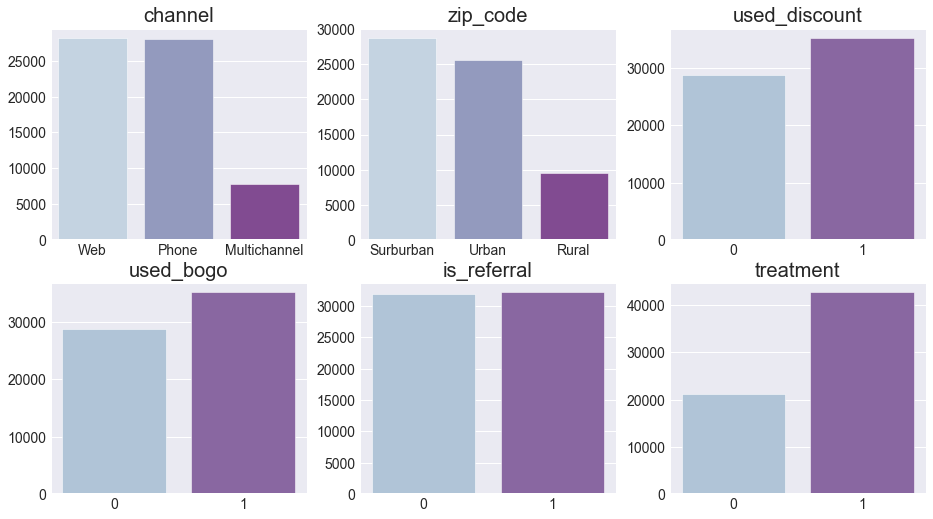

In [9]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(14, 8))

for i, ax in enumerate(axes.flat):
    counts = df[cat_feature_names[i]].value_counts()
    print(str(cat_feature_names[i]))
    for name in counts.index:  
        print(f'{name} - {counts[name]/df.shape[0]*100:.0f}%')
    sns.barplot(counts.index, counts.values, ax=ax, palette='BuPu')
    ax.set_title(cat_feature_names[i])
    print('\n-------------------------')

plt.show()

#### 5.2. Количественные признаки

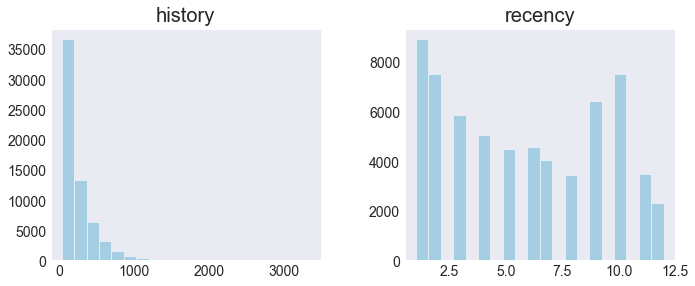

In [10]:
df[num_feature_names].hist(figsize=(10,4), bins=20, grid=False)
plt.show()

### 6. Разбиение на тренировочную и тестовую выборки

In [11]:
df_test = df[df['treatment'] == 0][:5000]

train_index = list(set(df.index) - set(df_test.index))
df_train = df.iloc[train_index]

df_train.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)
df_train

recency  history  used_discount  used_bogo   zip_code  is_referral  \
0           10   142.44              1          0  Surburban            0   
1            7   180.65              0          1  Surburban            1   
2            9   675.83              1          0      Rural            1   
3            2    45.34              1          0      Urban            0   
4            6   134.83              0          1  Surburban            0   
...        ...      ...            ...        ...        ...          ...   
58995       10   105.54              1          0      Urban            0   
58996        5    38.91              0          1      Urban            1   
58997        6    29.99              1          0      Urban            1   
58998        1   552.94              1          0  Surburban            1   
58999        1   472.82              0          1  Surburban            0   

            channel  treatment  target  
0             Phone          1       0  
1               Web          1       0  
2               Web          1       0  
3               Web          1       0  
4             Phone          1       1  
...             ...        ...     ...  
58995           Web          1       0  
58996         Phone          1       0  
58997         Phone          1       0  
58998  Multichannel          1       0  
58999           Web          1       0  

[59000 rows x 9 columns]

In [12]:
indices_train = df_train.index
indices_test = df_test.index
indices_learn, indices_valid = train_test_split(df_train.index, test_size=0.3, random_state=123)

X_train = df.loc[indices_learn, :]
y_train = df_train.loc[indices_learn, 'target']
treat_train = df_train.loc[indices_learn, 'treatment']

X_val = df.loc[indices_valid, :]
y_val = df_train.loc[indices_valid, 'target']
treat_val =  df_train.loc[indices_valid, 'treatment']

X_train_full = df.loc[indices_train, :]
y_train_full = df_train.loc[:, 'target']
treat_train_full = df_train.loc[:, 'treatment']

X_test = df.loc[indices_test, :]


models_results = {}
models_results['approach'] = []
models_results['uplift@10%'] = []
models_results['uplift@20%'] = []

X_train

recency  history  used_discount  used_bogo   zip_code  is_referral  \
57065        3   404.72              1          0  Surburban            0   
19415        3   105.48              1          0  Surburban            0   
54664        7    49.90              0          1      Urban            0   
47351        2   400.48              1          0      Urban            0   
5205        10   322.58              1          0  Surburban            1   
...        ...      ...            ...        ...        ...          ...   
54370        3    29.99              1          0      Urban            0   
17730        9    95.41              0          1  Surburban            0   
28030        1   547.69              1          1      Rural            1   
15725        5   341.39              0          1  Surburban            0   
52734        1    67.15              0          1      Rural            0   

            channel  treatment  target  
57065         Phone          1       1  
19415           Web          1       0  
54664           Web          0       0  
47351  Multichannel          1       0  
5205            Web          0       0  
...             ...        ...     ...  
54370         Phone          0       0  
17730         Phone          1       0  
28030  Multichannel          0       1  
15725         Phone          1       1  
52734           Web          1       0  

[41300 rows x 9 columns]

### 7. Feature engineering

In [13]:
#соберем наш простой pipeline, но нам понадобится написать класс для выбора нужного поля
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]

class NumericPower(BaseEstimator, TransformerMixin):
    def __init__(self, key, p):
        self.key = key
        self.columns = []
        self.p = p+1

    def fit(self, X, y=None):
        #self.columns = [self.key+'^'+str(col) for col in range(2,self.p)]
        return self

    def transform(self, X):
        Xp = X.copy()
       
        for i in range(2,self.p):
            self.columns += [self.key+'^'+str(i)]
            Xp[self.key+'^'+str(i)] = Xp[self.key].values ** i
        
        return Xp.loc[:,self.columns]
    
class Numericlog(BaseEstimator, TransformerMixin):
    def __init__(self, key, p):
        self.key = key
        self.columns = []
        self.p = p+1

    def fit(self, X, y=None):
        #self.columns = [self.key+'log_'+str(col) for col in range(2,self.p)]
        return self

    def transform(self, X):
        Xp = X.copy()
       
        for i in range(2,self.p):
            self.columns += [self.key+'log_'+str(i)]
            Xp[self.key+'log_'+str(i)] = np.log(np.abs(Xp[self.key].values)+0.01)/np.log(i)

        result = Xp.loc[:,self.columns]
        return result

class NumericMix(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []
        

    def fit(self, X, y=None):
        return self

    def transform(self, X):

        Xp = X[self.key].copy()
        #print(Xp)
        s = self.key
        for col1 in s[:-1]:
            for col2 in s[1:]:   
                Xp[col1+'/'+col2] = Xp.loc[:,col1].values/(np.abs(Xp.loc[:,col2].values)+0.01)

                Xp[col1+'*'+col2] = Xp.loc[:,col1].values*Xp.loc[:,col2].values
                self.columns += [col1+'/'+col2, col1+'*'+col2]
        return Xp.loc[:,self.columns]

class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]
      

cat_feature_names = ['channel', 'zip_code']
num_feature_names = ['recency', 'history']
not_transformed = ['used_discount', 'used_bogo', 'is_referral'] # почему я не могу добавить эти фичи
final_transformers = list()

for cat_col in ['channel', 'zip_code']:
    cat_transformer = Pipeline([
                ('selector', FeatureSelector(column=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    final_transformers.append((cat_col, cat_transformer))
    
for cont_col in num_feature_names:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col)),
#                 ('scaler1', NumericPower(key=cont_col, p=3)), # почему тут ломается?
                ('scaler', StandardScaler())
            ])
    final_transformers.append((cont_col, cont_transformer))
    
    
# for col in not_transformed:
#     col_selector = Pipeline([
#                 ('selector', FeatureSelector(column=col))
#             ])
#     final_transformers.append((col, col_selector))
    
feats = FeatureUnion(final_transformers)
feature_processing = Pipeline([('feats', feats)])

In [14]:
feature_processing = Pipeline([('feats', feats)])

In [15]:
final_transformers

[('channel',
  Pipeline(memory=None,
           steps=[('selector', FeatureSelector(column='channel')),
                  ('ohe', OHEEncoder(key='channel'))],
           verbose=False)),
 ('zip_code',
  Pipeline(memory=None,
           steps=[('selector', FeatureSelector(column='zip_code')),
                  ('ohe', OHEEncoder(key='zip_code'))],
           verbose=False)),
 ('recency',
  Pipeline(memory=None,
           steps=[('selector', NumberSelector(key='recency')),
                  ('scaler',
                   StandardScaler(copy=True, with_mean=True, with_std=True))],
           verbose=False)),
 ('history',
  Pipeline(memory=None,
           steps=[('selector', NumberSelector(key='history')),
                  ('scaler',
                   StandardScaler(copy=True, with_mean=True, with_std=True))],
           verbose=False))]

### 8. Обучение модели

#### 8.1. Одиночная модель

In [16]:
pipeline = Pipeline([
    ('features', feats),
    ('classifier', SoloModel(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True)))
])

In [17]:
#обучим наш пайплайн
sm = pipeline.fit(X_train, y_train, classifier__treatment=treat_train)

In [18]:
uplift_sm = sm.predict(X_val)
uplift_sm

array([0.07278996, 0.06719965, 0.05699801, ..., 0.05453526, 0.04445227,
       0.07246083])

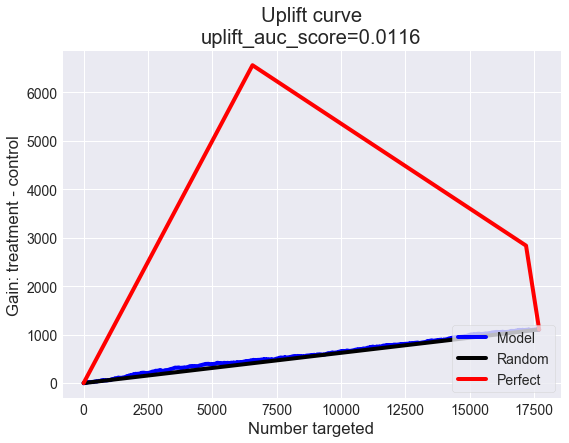

In [19]:
sm_score_10 = uplift_at_k(y_true=y_val, uplift=uplift_sm, treatment=treat_val, strategy='by_group', k=0.1)
sm_score_20 = uplift_at_k(y_true=y_val, uplift=uplift_sm, treatment=treat_val, strategy='by_group', k=0.2)

models_results['approach'].append('SoloModel')
models_results['uplift@10%'].append(sm_score_10)
models_results['uplift@20%'].append(sm_score_20)

# # Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
# sm_trmnt_preds = sm.trmnt_preds_
# # И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
# sm_ctrl_preds = sm.ctrl_preds_

from sklift.viz import plot_uplift_curve
plot_uplift_curve(y_true=y_val, uplift=uplift_sm, treatment=treat_val)

#### 8.2. Две модели

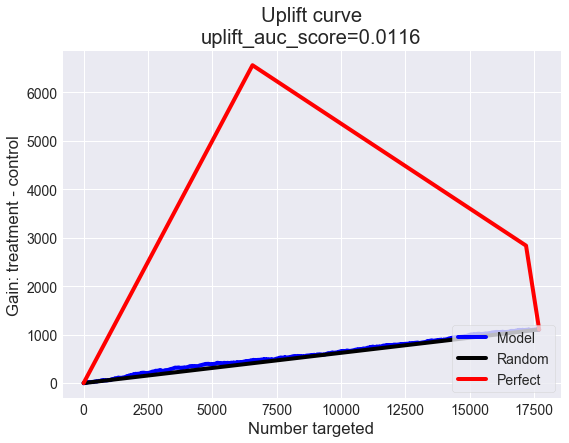

In [20]:
from sklift.models import TwoModels

pipeline = Pipeline([
    ('features', feats),
    ('classifier', TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    estimator_ctrl=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    method='vanilla'
))
])

pipeline.fit(
    X_train, y_train, classifier__treatment=treat_train)

uplift_tm = pipeline.predict(X_val)

tm_score10 = uplift_at_k(y_true=y_val, uplift=uplift_tm, treatment=treat_val, strategy='by_group', k=0.1)
tm_score20 = uplift_at_k(y_true=y_val, uplift=uplift_tm, treatment=treat_val, strategy='by_group', k=0.2)

models_results['approach'].append('TwoModels')
models_results['uplift@10%'].append(tm_score10)
models_results['uplift@20%'].append(tm_score20)

plot_uplift_curve(y_true=y_val, uplift=uplift_sm, treatment=treat_val)

#### 8.3. Трансформация классов

In [21]:
from sklift.models import ClassTransformation

pipeline = Pipeline([
    ('features', feats),
    ('classifier', ClassTransformation(CatBoostClassifier(iterations=20, 
                                                          thread_count=2, random_state=42, silent=True))) 

])

ct = pipeline.fit(
    X_train, y_train, classifier__treatment=treat_train)

uplift_ct = ct.predict(X_val)

ct_score10 = uplift_at_k(y_true=y_val, uplift=uplift_ct, treatment=treat_val, strategy='by_group', k=0.1)
ct_score20 = uplift_at_k(y_true=y_val, uplift=uplift_ct, treatment=treat_val, strategy='by_group', k=0.2)


models_results['approach'].append('ClassTransformation')
models_results['uplift@10%'].append(ct_score10)
models_results['uplift@20%'].append(ct_score20)

It is recommended to use this approach on treatment balanced data. Current sample size is unbalanced.


In [22]:
df_results = pd.DataFrame(models_results)
df_results

approach  uplift@10%  uplift@20%
0            SoloModel    0.085464    0.087107
1            TwoModels    0.099362    0.082172
2  ClassTransformation    0.102880    0.090440

Лучший результат получаем на трансформации классов.

### Строим UpliftTreeClassifier

In [23]:
X_train_tree = pd.concat([X_train.drop('zip_code', 1), pd.get_dummies(X_train['zip_code'], prefix='zip_code')], 1)
X_train_tree = pd.concat([X_train_tree.drop('channel', 1), pd.get_dummies(X_train_tree['channel'], prefix='channel')], 1)

X_train_tree.columns

Index(['recency', 'history', 'used_discount', 'used_bogo', 'is_referral',
       'treatment', 'target', 'zip_code_Rural', 'zip_code_Surburban',
       'zip_code_Urban', 'channel_Multichannel', 'channel_Phone',
       'channel_Web'],
      dtype='object')

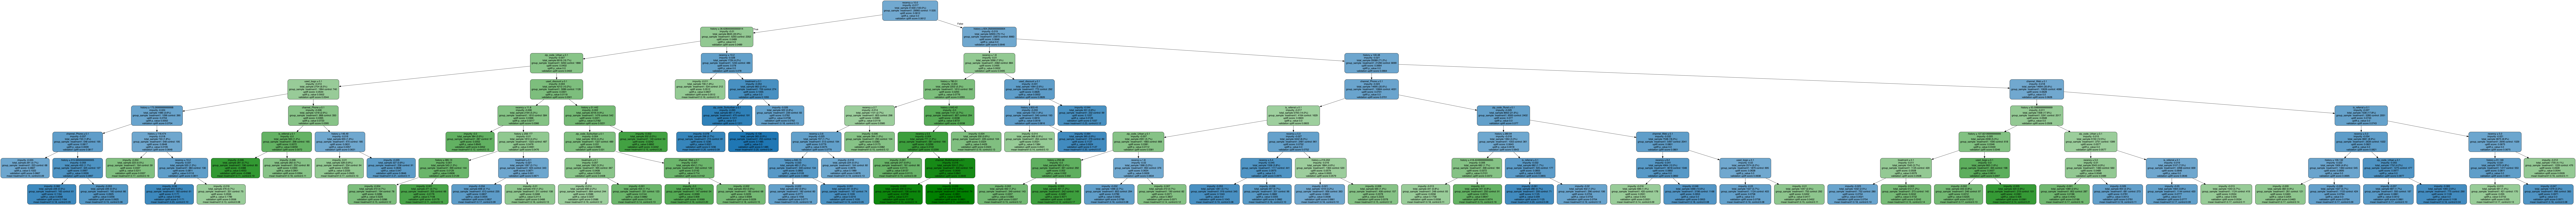

In [24]:
selected_for_tree = ['used_discount', 'used_bogo', 'is_referral', 'treatment', 'recency', 'history', 
                     'zip_code_Rural', 'zip_code_Surburban', 'zip_code_Urban', 'channel_Multichannel', 
                     'channel_Phone', 'channel_Web']

X_train_tree = X_train_tree[selected_for_tree]
features = [col for col in X_train_tree]

from IPython.display import Image
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.inference.tree import uplift_tree_string, uplift_tree_plot

uplift_model = UpliftTreeClassifier(max_depth=8, min_samples_leaf=200, min_samples_treatment=50,
                                    n_reg=100, evaluationFunction='KL', control_name='control')

uplift_model.fit(X_train_tree.values,
                 treatment=treat_train.map({1: 'treatment1', 0: 'control'}).values,
                 y=y_train)

graph = uplift_tree_plot(uplift_model.fitted_uplift_tree, features)
Image(graph.create_png())

По дереву видим, что хорошее значение аплифт (0.09) получаем на пользователях (более 10% выборки), которые совершали последнюю покупку не раньше, чем 8 месяцев назад, совершили в целом больше 289 покупок через канал web и при этом относятся к сельскому населению.